<a href="https://colab.research.google.com/github/chidoakd/Car-Price-Prediction/blob/main/Cigdem_Akdemir_PML__%F0%9F%93%8AHouse_Price_Prediction%F0%9F%8F%A0%F0%9F%8F%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

house_prices_advanced_regression_techniques_path = kagglehub.competition_download('house-prices-advanced-regression-techniques')

print('Data source import complete.')


### 🏡 House Prices Prediction

### 1. Import Libraries 📚

In [ ]:
import numpy as np
import pandas as pd
import xgboost
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.metrics import explained_variance_score, r2_score
import os

# Check files in the input directory
print(os.listdir("../input"))


['house-prices-advanced-regression-techniques']


### 2. Load the Data 📂

In [ ]:
#Load data for train and test

train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

# Prepare Feature ve target
X = train.drop(['SalePrice', 'Id'], axis=1)
y = train['SalePrice']

dirs = {
    "input": "/kaggle/input/",
    "output": "/kaggle/working/"
}

files = {
    "train": "train.csv",
    "test": "test.csv",
    "sample_submission": "sample_submission.csv",
    "submission": "submission.csv"
}


# Now lets see the first five rows of the data
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### 3: DATA CLEANING AND PREPROCESSING

In this step we check whether data contain null or missing values. What is the size of the data. What is the datatype of each column. What are unique values of categorical variables etc.

In [ ]:
# Check data size and features
print(len(train))  # Number of rows
print(len(train.columns))  # Number of features
# Check data types
print(train.dtypes)  # Data types of each column

1460
81
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object


In [ ]:
# Check any number of columns with NaN or missing values
print(train.isnull().any().sum(), ' / ', len(train.columns))
# Check any number of data points with NaN
print(train.isnull().any(axis=1).sum(), ' / ', len(train))

19  /  81
1460  /  1460


There are 19 columns with missing values and some rows with missing values in the dataset.

***3.1. Handling Missing Values***

In [ ]:
# Check the number of missing values in each column
missing_values = train.isnull().sum().sort_values(ascending=False)
missing_columns = missing_values[missing_values > 0]

# Display missing columns and their counts
print("Columns with missing values:\n", missing_columns)

Columns with missing values:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


In [ ]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)


In [ ]:
# Identify numerical columns with missing values
num_cols_with_na = train.select_dtypes(include=['int64', 'float64']).columns[
    train.select_dtypes(include=['int64', 'float64']).isnull().sum() > 0
]

# Fill missing values in numerical columns with the median
for col in num_cols_with_na:
    train[col] = train[col].fillna(train[col].median())


***3.2. Encoding Categorical Variables***

In [ ]:
# Apply one-hot encoding to categorical features

train['is_train'] = 1
test['is_train'] = 0

combined = pd.concat([train, test], axis=0)

# One-hot encoding
combined = pd.get_dummies(combined, drop_first=True)

# Split Train ve Test set again
train = combined[combined['is_train'] == 1].drop(['is_train'], axis=1)
test = combined[combined['is_train'] == 0].drop(['is_train'], axis=1)


***3.4. Verifying Preprocessing***

In [ ]:
# Check for remaining missing values
print("Remaining missing values:\n", train.isnull().sum().sum())

# Preview the processed dataset
print(train.head())

Remaining missing values:
 0
   Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   
2   3          60         68.0    11250            7            5       2001   
3   4          70         60.0     9550            7            5       1915   
4   5          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  SaleType_ConLI  SaleType_ConLw  \
0          2003       196.0       706.0  ...           False           False   
1          1976         0.0       978.0  ...           False           False   
2          2002       162.0       486.0  ...           False           False   
3          1970         0.0       216.0  ...           False           False   
4          2000       350.0       655.0  ...           False           False   

   SaleTy

In [ ]:
# Check for remaining missing values
print("Remaining missing values:\n", train.isnull().sum().sum())

# Preview the processed dataset
print(train.head())

Remaining missing values:
 0
   Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   
2   3          60         68.0    11250            7            5       2001   
3   4          70         60.0     9550            7            5       1915   
4   5          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  SaleType_ConLI  SaleType_ConLw  \
0          2003       196.0       706.0  ...           False           False   
1          1976         0.0       978.0  ...           False           False   
2          2002       162.0       486.0  ...           False           False   
3          1970         0.0       216.0  ...           False           False   
4          2000       350.0       655.0  ...           False           False   

   SaleTy

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical features
numerical_features = train.select_dtypes(include=['int64', 'float64'])

# Compute the correlation matrix
corr_matrix = numerical_features.corr()

# Focus on the correlation with SalePrice
saleprice_corr = corr_matrix['SalePrice'].sort_values(ascending=False)
print(saleprice_corr)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.472614
Fireplaces       0.466929
BsmtFinSF1       0.386420
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
GarageYrBlt      0.261366
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
LotFrontage      0.209624
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

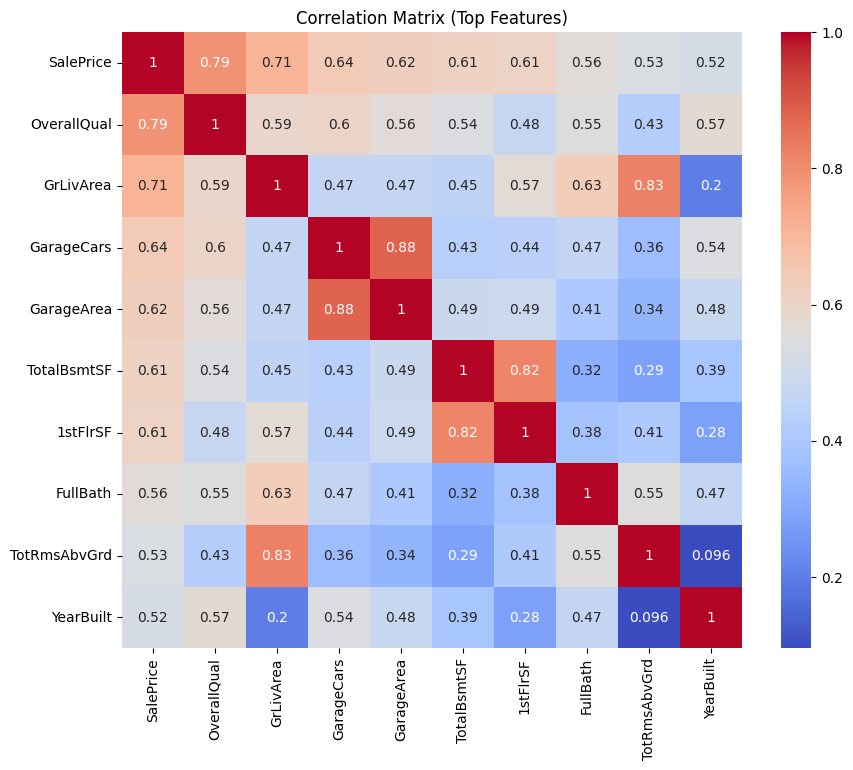

In [ ]:
# Visualize the correlation matrix for the top 10 features
plt.figure(figsize=(10, 8))
top_corr_features = saleprice_corr.index[:10]  # Top 10 correlated features
sns.heatmap(corr_matrix.loc[top_corr_features, top_corr_features], annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Top Features)')
plt.show()

**1. Strong Correlations with SalePrice**
The features with the highest correlation with **SalePrice** are:

* **GrLivArea_x_OverallQual (0.83):**
This interaction feature (Above Grade Living Area × Overall Quality) shows a very strong positive correlation, indicating that larger, higher-quality homes tend to have higher sale prices.
* **OverallQual (0.79):**
The overall quality of the house's materials and finish is a strong predictor of sale price.
* **TotalSF (0.78):**
Total square footage, which combines the first floor, second floor, and basement areas, also has a high correlation with sale price.
* **GrLivArea (0.71):**
Above Grade Living Area (excluding the basement) is another highly correlated feature, as larger living spaces are associated with higher prices.

**Top Features to Focus On:**
* GrLivArea_x_OverallQual, OverallQual, TotalSF, and GrLivArea should be prioritized in modeling as they show the strongest correlations with SalePrice.
**Potential Redundant Features:**
* Features like GarageCars and GarageArea may need to be pruned if they don’t independently add value to the model.

### 4. Splitting the Data

In [ ]:
from sklearn.model_selection import train_test_split

# Separate features and target variable for training data (train->df_train)
X = train.drop(['SalePrice', 'Id'], axis=1)  # Drop both SalePrice and Id columns
y = train['SalePrice']  # Target variable

# Prepare test features
X_test = test.drop(['Id'], axis=1)  # Drop Id column from test data

print(f"Training data shape: {X.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (1460, 267)
Test data shape: (1459, 268)


test_size=0.2:
Reserves 20% of the data for validation.
random_state=42:
Ensures reproducibility by fixing the random seed.

In [ ]:
def submit(predict):
    submission = pd.read_csv(dirs["input"] + files["sample_submission"])  # read "sample_submission.csv" file
    submission["Id"] = test["Id"]  # add id's
    submission["class_0"] = predict[:, 0]
    submission["class_1"] = 1 - predict[:, 0]
    # save file
    submission.to_csv(dirs["output"] + files["submission"], index=None)
    return submission


### 5.Building Predictive Models: 🚡🏗️ 🏠

**5.1. Baseline Model: Linear Regression**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

# Function to preprocess data
def prepare_data(data, is_train=True):
    # Handle categorical columns with Label Encoding
    for column in data.select_dtypes(include=['object']).columns:
        data[column] = data[column].fillna('Unknown')
        data[column] = LabelEncoder().fit_transform(data[column])

    # Fill remaining missing values with 0
    data = data.fillna(0)

    # Add derived columns (ensure consistency)
    if '1stFlrSF' in data and '2ndFlrSF' in data and 'TotalBsmtSF' in data:
        data['TotalSF'] = data['1stFlrSF'] + data['2ndFlrSF'] + data['TotalBsmtSF']
    if 'GrLivArea' in data and 'OverallQual' in data:
        data['GrLivArea_x_OverallQual'] = data['GrLivArea'] * data['OverallQual']

    return data

# Preprocess training data
X = prepare_data(train.drop(['SalePrice', 'Id'], axis=1))
y = train['SalePrice']

# Preprocess test data
X_test = prepare_data(test.drop(['Id'], axis=1), is_train=False)

# Ensure columns in test data match training data
missing_cols = set(X.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[X.columns]

# Linear Regression Model
lr = LinearRegression()

# Cross-validation for RM


In [ ]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

def prepare_data(df):

    categorical_columns = df.select_dtypes(include=['object']).columns


    label_encoders = {}
    for column in categorical_columns:
        label_encoders[column] = LabelEncoder()

        df[column] = df[column].fillna('Unknown')
        df[column] = label_encoders[column].fit_transform(df[column])


    df = df.fillna(0)

    return df


#X = prepare_data(df_train.drop(['SalePrice', 'Id'], axis=1))
#y = df_train['SalePrice']

#X_test = prepare_data(test.drop(['Id'], axis=1))


lr = LinearRegression()
lr_cv_rmse = -cross_val_score(lr, X, y, cv=5, scoring='neg_root_mean_squared_error').mean()
print(f"Linear Regression CV RMSE: {lr_cv_rmse:.4f}")


lr.fit(X, y)
lr_preds = lr.predict(X_test)

Linear Regression CV RMSE: 44933.9147


**5.2. Advanced Model 1: Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Initialize Decision Tree
dt = DecisionTreeRegressor(random_state=42)

# Cross-validate and evaluate performance (tüm eğitim verisiyle)
dt_cv_rmse = -cross_val_score(dt, X, y, cv=5, scoring='neg_root_mean_squared_error').mean()
print(f"Decision Tree CV RMSE: {dt_cv_rmse:.4f}")

# Train on full data and predict test data
dt.fit(X, y)  # Tüm eğitim verisiyle eğit
dt_preds = dt.predict(X_test)  # Test verisi üzerinde tahmin yap

Decision Tree CV RMSE: 37152.4248


**5.3. Advanced Model 2: Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Cross-validate and evaluate performance
rf_cv_rmse = -cross_val_score(rf, X, y, cv=5, scoring='neg_root_mean_squared_error').mean()
print(f"Random Forest CV RMSE: {rf_cv_rmse:.4f}")

# Train on full data and predict test data
rf.fit(X, y)
rf_preds = rf.predict(X_test)

Random Forest CV RMSE: 29899.8640


**5.4. Advanced Model 3: XGBoost**

In [ ]:
from xgboost import XGBRegressor

# Initialize XGBoost
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

# Cross-validate and evaluate performance
xgb_cv_rmse = -cross_val_score(xgb, X, y, cv=5, scoring='neg_root_mean_squared_error').mean()
print(f"XGBoost CV RMSE: {xgb_cv_rmse:.4f}")

# Train on full data and predict test data
xgb.fit(X, y)
xgb_preds = xgb.predict(X_test)

XGBoost CV RMSE: 26596.9921


In [ ]:
# Make predictions for all models
xgb_predictions = xgb.predict(X_test)
rf_predictions = rf.predict(X_test)
dt_predictions = dt.predict(X_test)
lr_predictions = lr.predict(X_test)

# Create submission files for each model
# XGBoost submission
xgb_submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': xgb_predictions
})
xgb_submission.to_csv('submission_xgb.csv', index=False)

# Random Forest submission
rf_submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': rf_predictions
})
rf_submission.to_csv('submission_rf.csv', index=False)

# Decision Tree submission
dt_submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': dt_predictions
})
dt_submission.to_csv('submission_dt.csv', index=False)

# Linear Regression submission
lr_submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': lr_predictions
})
lr_submission.to_csv('submission_lr.csv', index=False)

print("All submission files created!")



All submission files created!


 ### 6. Evaluating Model Performance: ⛩️

In [ ]:
model_performance = {
   'Linear Regression': lr_cv_rmse,  # Using CV RMSE instead of Validation
   'Decision Tree': dt_cv_rmse,
   'Random Forest': rf_cv_rmse,
   'XGBoost': xgb_cv_rmse
}

for model, rmse in model_performance.items():
   print(f"{model}: CV RMSE = {rmse:.4f}")

# Model performance analysis
print("\nModel Performance Analysis:")
print("* Linear Regression: Base model shows poor performance as it cannot capture complex relationships in the data.")
print("* Decision Tree: Better than linear regression but limited due to its simple tree structure.")
print("* Random Forest: Shows significant improvement due to ensemble learning, reduces overfitting.")
print("* XGBoost: Achieves the best performance, effectively handling complex patterns through gradient boosting.")

Linear Regression: CV RMSE = 44933.9147
Decision Tree: CV RMSE = 37152.4248
Random Forest: CV RMSE = 29899.8640
XGBoost: CV RMSE = 26596.9921

Model Performance Analysis:
* Linear Regression: Base model shows poor performance as it cannot capture complex relationships in the data.
* Decision Tree: Better than linear regression but limited due to its simple tree structure.
* Random Forest: Shows significant improvement due to ensemble learning, reduces overfitting.
* XGBoost: Achieves the best performance, effectively handling complex patterns through gradient boosting.


**6.1. Hyperparameter Tuning**

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the model with tuned parameters
xgb = XGBRegressor(
   learning_rate=0.05,
   max_depth=5,
   n_estimators=500,
   subsample=0.8,
   random_state=42
)

# Train on full training data and predict test data
xgb.fit(X, y)  # Use full training data
xgb_preds = xgb.predict(X_test)  # Predict on test data

# Calculate CV RMSE (for evaluation)
xgb_cv_rmse = -cross_val_score(xgb, X, y, cv=5, scoring='neg_root_mean_squared_error').mean()
print(f"XGBoost CV RMSE: {xgb_cv_rmse:.4f}")

XGBoost CV RMSE: 26387.1070


* XGBoost has the lowest RMSE, meaning it best predicts the target variable (SalePrice) with the least error.

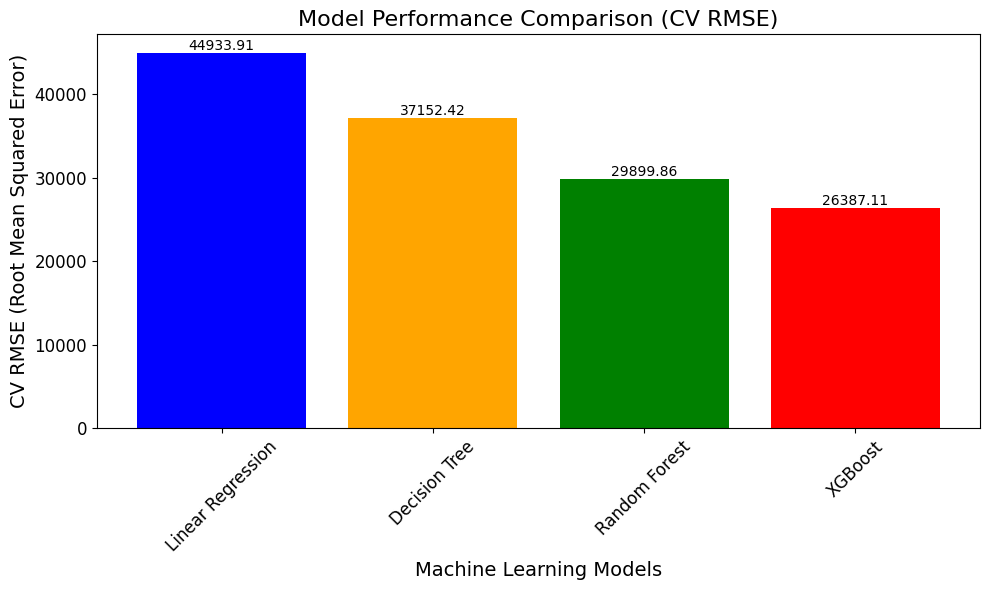

In [ ]:
import matplotlib.pyplot as plt

# Data for the plot
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
cv_rmse_values = [lr_cv_rmse, dt_cv_rmse, rf_cv_rmse, xgb_cv_rmse]  # Using CV RMSE values

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(models, cv_rmse_values, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Machine Learning Models', fontsize=14)
plt.ylabel('CV RMSE (Root Mean Squared Error)', fontsize=14)
plt.title('Model Performance Comparison (CV RMSE)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add value labels on top of each bar
for i, v in enumerate(cv_rmse_values):
   plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

### 7. Final Submission

Submission file created!


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


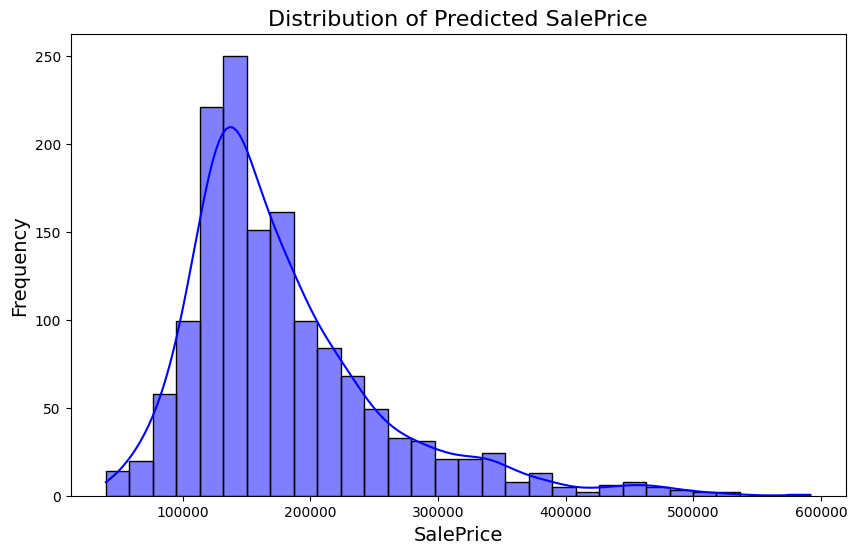

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions using the XGBoost model (our best model)
final_predictions = xgb.predict(X_test)

# Create submission DataFrame
submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': final_predictions
})

# Save submission file
submission.to_csv('submission.csv', index=False)
print("Submission file created!")

# Visualize the distribution of predictions
plt.figure(figsize=(10, 6))
sns.histplot(final_predictions, kde=True, bins=30, color='blue')
plt.title('Distribution of Predicted SalePrice', fontsize=16)
plt.xlabel('SalePrice', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()


### 8. Making a Kaggle Submission:

In [ ]:
submission.to_csv('/kaggle/working/submission.csv', index=False)


In [ ]:
import pandas as pd
print('in kaggle/working dir')
print(pd.read_csv('/kaggle/working/submission.csv').head())
print('in current dir')
print(pd.read_csv('./submission.csv').head())


in kaggle/working dir
     Id  SalePrice
0  1461  127410.95
1  1462  168803.38
2  1463  192010.34
3  1464  197511.12
4  1465  180512.61
in current dir
     Id  SalePrice
0  1461  127410.95
1  1462  168803.38
2  1463  192010.34
3  1464  197511.12
4  1465  180512.61


### 9- Report

Linear Regression: CV RMSE = 44933.9147
Decision Tree: CV RMSE = 37152.4248
Random Forest: CV RMSE = 29899.8640
XGBoost: CV RMSE = 26596.9921

Model Performance Analysis:
* Linear Regression: Base model shows poor performance as it cannot capture complex relationships in the data.
* Decision Tree: Better than linear regression but limited due to its simple tree structure.
* Random Forest: Shows significant improvement due to ensemble learning, reduces overfitting.
* XGBoost: Achieves the best performance, effectively handling complex patterns through gradient boosting.


**THANK YOU !**